In [12]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import numpy as np
import seaborn as sns
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import optim

In [13]:
batch_size_train = 64
batch_size_test = 64

In [14]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.STL10('/files/', split='train', folds=1, download=True,
                               transform=transform),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.STL10('/files/', split='test', folds=1, download=True,
                               transform=transform),
    batch_size=64, shuffle=True)

100%|██████████| 2.64G/2.64G [01:01<00:00, 42.8MB/s]


In [15]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v3_large', weights="DEFAULT")
model.classifier.out_features = 10

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 153MB/s]


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00003)

In [17]:
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total
    return running_loss / len(loader), accuracy

def test(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return running_loss / len(loader), accuracy


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy = test(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Epoch 1/10, Train Loss: 7.4856, Train Accuracy: 0.00%, Test Loss: 7.2976, Test Accuracy: 0.07%
Epoch 2/10, Train Loss: 5.6348, Train Accuracy: 2.40%, Test Loss: 6.2733, Test Accuracy: 0.36%
Epoch 3/10, Train Loss: 3.9336, Train Accuracy: 21.10%, Test Loss: 5.2655, Test Accuracy: 3.19%
Epoch 4/10, Train Loss: 2.4807, Train Accuracy: 48.00%, Test Loss: 4.3486, Test Accuracy: 11.66%
Epoch 5/10, Train Loss: 1.6290, Train Accuracy: 60.40%, Test Loss: 3.5276, Test Accuracy: 23.95%
Epoch 6/10, Train Loss: 1.1334, Train Accuracy: 71.80%, Test Loss: 2.8732, Test Accuracy: 35.30%
Epoch 7/10, Train Loss: 0.8267, Train Accuracy: 77.00%, Test Loss: 2.3194, Test Accuracy: 45.59%
Epoch 8/10, Train Loss: 0.6394, Train Accuracy: 83.30%, Test Loss: 1.8734, Test Accuracy: 55.09%
Epoch 9/10, Train Loss: 0.4799, Train Accuracy: 88.20%, Test Loss: 1.5281, Test Accuracy: 62.65%
Epoch 10/10, Train Loss: 0.3845, Train Accuracy: 91.10%, Test Loss: 1.2541, Test Accuracy: 68.78%


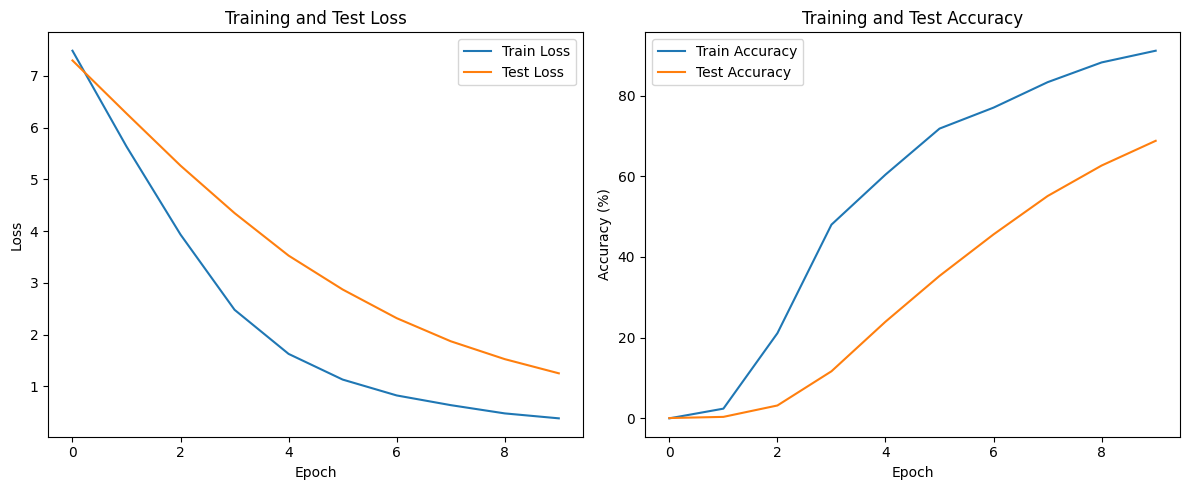

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


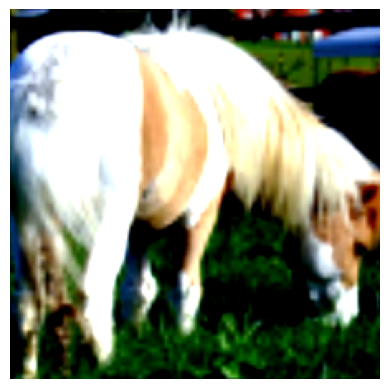

Predicted: 7, Actual: 6


In [20]:
def imshow(img):
    img = img / 2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

def test_random_image(model, loader, device):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)

    import random
    index = random.randint(0, images.size(0) - 1)
    image = images[index].unsqueeze(0)
    label = labels[index].item()

    output = model(image)
    _, predicted = torch.max(output, 1)
    predicted = predicted.item()

    imshow(image.cpu().squeeze())
    print(f'Predicted: {predicted}, Actual: {label}')

test_random_image(model, test_loader, device)

In [21]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v3_large', pretrained=False)
model.classifier.out_features = 10

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy = test(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Epoch 1/10, Train Loss: 6.9091, Train Accuracy: 0.10%, Test Loss: 6.9078, Test Accuracy: 0.00%
Epoch 2/10, Train Loss: 6.9096, Train Accuracy: 0.10%, Test Loss: 6.9078, Test Accuracy: 0.00%
Epoch 3/10, Train Loss: 6.9102, Train Accuracy: 0.10%, Test Loss: 6.9078, Test Accuracy: 0.00%
Epoch 4/10, Train Loss: 6.9090, Train Accuracy: 0.20%, Test Loss: 6.9078, Test Accuracy: 0.00%
Epoch 5/10, Train Loss: 6.9090, Train Accuracy: 0.00%, Test Loss: 6.9078, Test Accuracy: 0.00%
Epoch 6/10, Train Loss: 6.9093, Train Accuracy: 0.00%, Test Loss: 6.9078, Test Accuracy: 0.00%
Epoch 7/10, Train Loss: 6.9089, Train Accuracy: 0.10%, Test Loss: 6.9078, Test Accuracy: 0.00%
Epoch 8/10, Train Loss: 6.9086, Train Accuracy: 0.00%, Test Loss: 6.9078, Test Accuracy: 0.00%
Epoch 9/10, Train Loss: 6.9091, Train Accuracy: 0.20%, Test Loss: 6.9078, Test Accuracy: 0.00%
Epoch 10/10, Train Loss: 6.9087, Train Accuracy: 0.00%, Test Loss: 6.9078, Test Accuracy: 0.00%


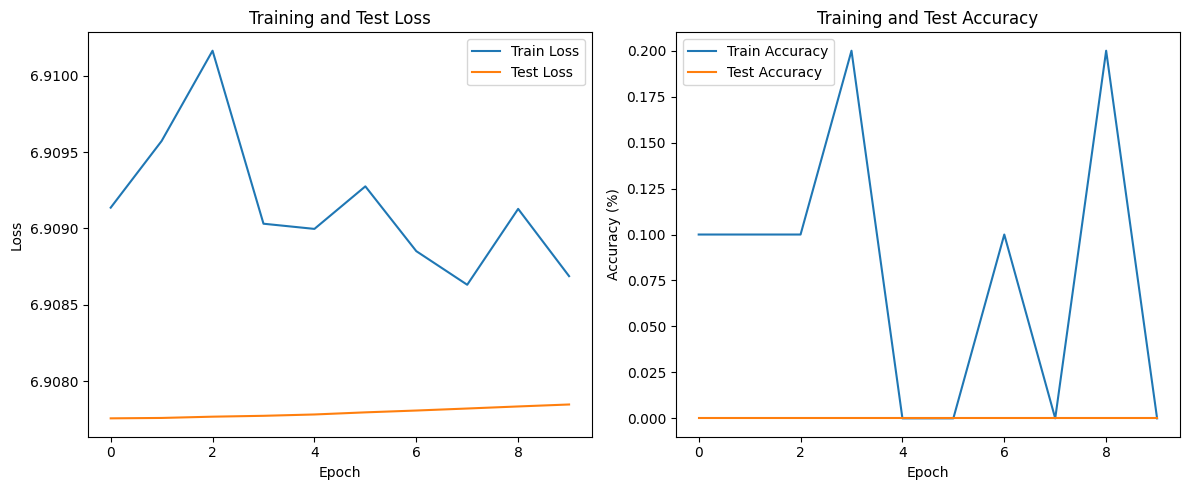

In [23]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


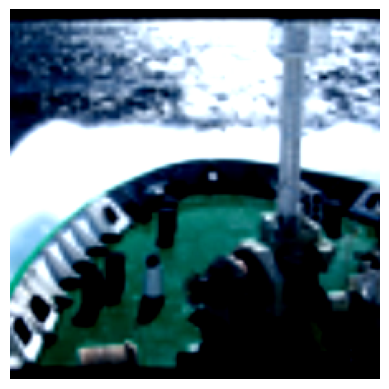

Predicted: 193, Actual: 8


In [24]:
def imshow(img):
    img = img / 2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

def test_random_image(model, loader, device):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)

    import random
    index = random.randint(0, images.size(0) - 1)
    image = images[index].unsqueeze(0)
    label = labels[index].item()

    output = model(image)
    _, predicted = torch.max(output, 1)
    predicted = predicted.item()

    imshow(image.cpu().squeeze())
    print(f'Predicted: {predicted}, Actual: {label}')

test_random_image(model, test_loader, device)